In [2]:
import math
import random
import numpy as np
import pandas as pd

def make_signal(n, x_offset, y_offset, omega=0.15):
    return [math.sin(omega*(x + x_offset)) + y_offset for x in range(n)]

def generate_dummy_signals(N, n):
    timeseries = []
    y = []
    for i in range(N):
        if i%2:
            timeseries.append(make_signal(n, random.random()*10, -5))
            y.append(-5)
        else:
            timeseries.append(make_signal(n, random.random()*10, 5))
            y.append(5)
    return timeseries, y

In [3]:
import matplotlib.pyplot as plt

def visualize_signal(signal, c=None, vmin=None, vmax=None):
    plt.scatter(np.arange(len(signal)), signal, c=c, cmap="RdBu", vmin=vmin, vmax=vmax)

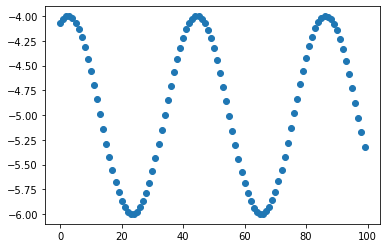

In [4]:
len_signals = 100
num_signals = 1000


signals, y = generate_dummy_signals(num_signals, len_signals)

visualize_signal(signals[1])

In [5]:
signals_df = pd.DataFrame(signals)
y = pd.Series(y)
print(signals_df.shape)

(1000, 100)


In [6]:
means = np.mean(signals_df, axis=1)
stds = np.std(signals_df, axis=1)

X = pd.concat([means, stds], axis="columns", keys=["mean", "std"])

In [7]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X, y)

preds = model.predict(X)
print("Model accuracy: %0.f" % (np.mean(preds==y)*100))

Model accuracy: 100


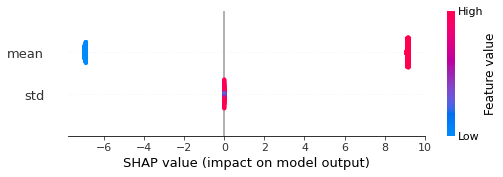

In [8]:
import shap

explainer = shap.LinearExplainer(model, masker=shap.maskers.Independent(data=X))
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, pd.DataFrame(X, columns=X.columns))

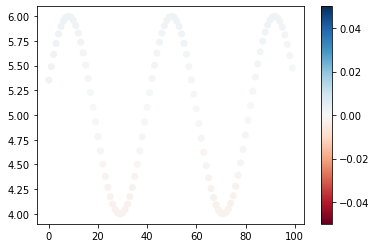

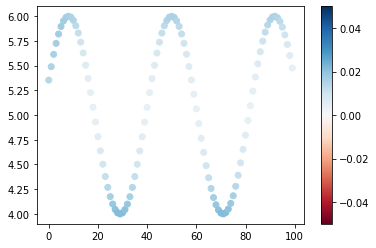

9.1917705937372
9.191770593737198


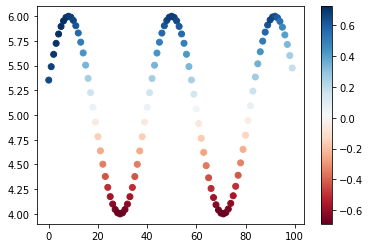

In [13]:
def occlude(signal, algorithm, start, size):
    occluded = signal.copy()
    endpoint_1 = signal[start]
    if start+size-1 < len(signal):
        endpoint_2 =signal[start+size-1]
    else:
        endpoint_2 = signal[len(signal)-1]
        
    if algorithm == "linear":
        occluded[start:start+size] = np.linspace(endpoint_1, endpoint_2, len(occluded[start:start+size]))
        return occluded
            
    if algorithm == "mean":
        value = signal[start:start+size].mean()
        
    if algorithm == "start":
        value = signal[start]
        
    if algorithm == "mean_endpoints":
        value = (endpoint_1 + endpoint_2) / 2
    
    occluded[start:start+size] = value
    return occluded

def run_occlusion(signal, feature_algos, algorithm, window_size=10):
    base_values = []
    for algo in feature_algos:
        base_values.append(algo(signal))
    v = np.zeros((len(signal), len(feature_algos)))
    hits = np.zeros(len(signal))
    for start in range(len(signal)):
        occluded = occlude(signal, "linear", start, window_size)
        new_values = []
        for algo in feature_algos:
            new_values.append(algo(occluded))
        for i in range(len(base_values)):
            v[start:start+window_size, i] += ((base_values[i] - new_values[i]) / np.abs(base_values[i])) 
        hits[start:start+window_size] += 1

    v = v / hits.reshape(-1, 1)
    return v

def distribute_shap(shap_values, v):
    v_norm = v / sum(v)
    return shap_values * v_norm
    

signal = signals_df.iloc[0]
x = X.iloc[0]

v = run_occlusion(signal, [np.mean, np.std], "linear")
    
visualize_signal(signal, c=v[:,0], vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()
    
visualize_signal(signal, c=v[:,1], vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()

weighted_shap = distribute_shap(shap_values[0,0], v[:,0])

visualize_signal(signal, c=weighted_shap)
plt.colorbar()
plt.show()

NOTES:
1. Window size matters a lot when checking change in STD using MEAN VALUE occlusion - but this should only change the range, not the order (TBD)
2. Using MEAN VALUE occlusion will never result in a change in MEAN
3. Need to be careful about end point - might be algo dependant 